<a href="https://colab.research.google.com/github/dafnesilla/PDI_IB_ENE2025/blob/main/Pr%C3%A1ctica_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Llamamos a las librerías de cv2, numpy, matplotlib y **scipy optimize** que esta última proporciona una variedad de algoritmos para resolver problemas de optimización. En este caso utilizamos la función minimize, que es clave para la segmentación óptima.

In [9]:
#Pesos óptimos
img = cv2.imread('Te-me_0015.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
R, G, B = img_rgb[:, :, 0], img_rgb[:, :, 1], img_rgb[:, :, 2]

R_norm = R.astype(np.float32) / 255
G_norm = G.astype(np.float32) / 255
B_norm = B.astype(np.float32) / 255

def grayscale_variance(weights):
    w_r, w_g, w_b = weights
    gray = w_r * R_norm + w_g * G_norm + w_b * B_norm
    gray_normalized = (gray - gray.min()) / (gray.max() - gray.min())
    return -np.var(gray_normalized)

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

bounds = [(0, 1), (0, 1), (0, 1)]

initial_weights = [0.33, 0.33, 0.34]

result = minimize(grayscale_variance, initial_weights, method='SLSQP',
                  bounds=bounds, constraints=constraints)

optimal_weights = result.x
print("Pesos óptimos:", optimal_weights)

Pesos óptimos: [0.33 0.33 0.34]


Agregamos la imágen que vamos a utilizar que en este caso es la que se nos proporcionó para hacer la práctica. Primero cargamos la imagen original y la pasamos a RGB, después se separan los canales y se define la función grayscale_variance que crea la imagen en escala de grises y después se normalizan los valores al rango [0,1] lo que es necesario para la optimización, después se fuerza a que los numeros sumen 1 por normalización y después se aplica el **Sequencial Least Squares Programming** (SLSQP) para encontrar la combinación óptima de pesos.



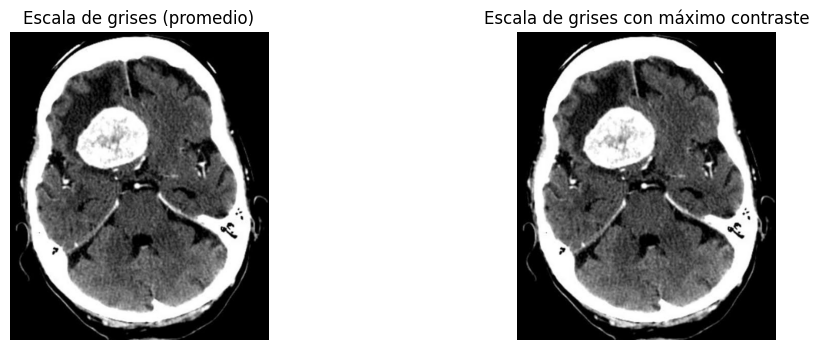

In [13]:
#Escala de grises óptima
gray_optimal = optimal_weights[0] * R_norm + optimal_weights[1] * G_norm + optimal_weights[2] * B_norm
gray_optimal = (gray_optimal * 255).astype(np.uint8)

gray_avg = ((R.astype(np.float32) + G + B) / 3).astype(np.uint8)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(gray_avg, cmap='gray')
plt.title('Escala de grises (promedio)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gray_optimal, cmap='gray')
plt.title('Escala de grises con máximo contraste')
plt.axis('off')
plt.show()



Aplicamos el arreglo de **"optimal_weights"** que contiene los pesos calculados en el formato pasado con el método SLSQP, se combinan los canales R,G y B normalizados, después se toma el promedio simple de los tres canales para obtener la escala de grises. Después se crea una figura 12x4 y después se muestra la imagen convertida a escala de grises promedio y después se muestra la imagen convertida a escala de grises utilizando los pesos optimizados.

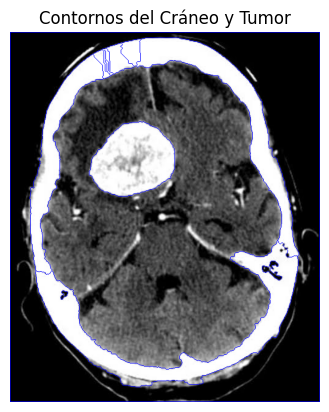

In [18]:
#Contorno del craneo y del tumor
_, binary = cv2.threshold(gray_optimal, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.ones((3,3), np.uint8)
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

sure_bg = cv2.dilate(opening, kernel, iterations=3)

dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
_, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

img_marked = img_rgb.copy()
markers = cv2.watershed(img, markers)
img_marked[markers == -1] = [0, 0, 255]

plt.imshow(img_marked)
plt.title('Contornos del Cráneo y Tumor')
plt.axis('off')
plt.show()

La función **binary** iene como propósito convertir la imágen en escala de grises guardada en "gray_optimal" en una imágen binaria. La función devuelve un valor de umbral y la imágen binarizada.

Después se elimina el ruido en la imágen binaria con la función kernel y se repite 2 veces para mejorar la limpieza del ruido, después identificamos las zonas que pertenecen al fondo. Se estiman las regiones que pertenecen a los objetos de interés, calculamos las regiones que no se pueden clasificar de forma segura bajo la función **"unknown"** y después se marcan las diferentes regiones del primer plano seguro para que el algoritmo Watershed identifique los límites entre ellas.
Se refinan los limites de las regiones usando el mismo algoritmo y finalmente se visualiza la imágen con los contornos resaltados en color azul.

In [17]:
#area del tumor

tumor_area_pixels = np.sum(markers == 2)
print(f'Área del tumor (píxeles): {tumor_area_pixels}')

pixel_spacing = 0.5
tumor_area_mm2 = tumor_area_pixels * (pixel_spacing ** 2)
print(f'Área del tumor (mm²): {tumor_area_mm2:.2f}')


Área del tumor (píxeles): 14001
Área del tumor (mm²): 3500.25


Este código traduce una segmentación binaria (en pixeles) a una medida útil, o sea, el área del tumor en unidades reales.